<a href="https://colab.research.google.com/github/parwezk/AI/blob/main/Reflection_Langgraph_OA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.** Reflection and Refinement in LangGraph**

LangGraph allows us to build agentic systems as cyclical graphs. This is perfect for the reflection and refinement pattern, where an initial plan is generated and then passed to another "critic" agent (or the same agent with a different prompt) to critique and improve it. The process can loop until the plan meets a certain quality standard.

In [ ]:
# Install necessary libraries
!pip install -qU langchain langchain-openai python-dotenv langgraph autogenstudio requests --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.9/296.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.

In [ ]:
# Import libraries and configure the API key
import os
import requests
import json
from datetime import datetime, timedelta
from google.colab import userdata
from dotenv import load_dotenv
from IPython.display import Image, display

In [ ]:
# Load environment variables (optional, for local development)
load_dotenv()

False

In [ ]:
# Configure the OpenAI API key for Colab
try:
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
except userdata.SecretNotFoundError:
    if "OPENAI_API_KEY" not in os.environ:
        print("OPENAI_API_KEY not found. Please set it as a Colab secret or in your environment.")

=== LANGGRAPH WORKFLOW VISUALIZATION ===


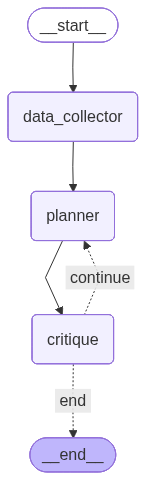


=== DECISION FLOW EXPLANATION ===
1. START → data_collector
   ↓
2. data_collector → planner
   ↓
3. planner → critique
   ↓
4. critique → DECISION POINT:
   ├─ IF iteration_count > 3 → END
   ├─ IF 'excellent' AND 'no changes' → END
   └─ ELSE → planner (LOOP BACK)

This creates a feedback loop where the planner
refines the itinerary based on critique until
it's satisfactory or max iterations reached.

=== EXECUTING WORKFLOW WITH STEP TRACKING ===
Starting workflow execution...
---DATA COLLECTION NODE---

📍 Current Node: DATA_COLLECTOR
   Iteration Count: 0
---PLANNER NODE---

📍 Current Node: PLANNER
   Iteration Count: 1
---CRITIQUE NODE---
---CHECKING CONDITION---

📍 Current Node: CRITIQUE
   Iteration Count: 1
   Critique: The plan is generally well-structured and detailed, but there are a few areas that could be improved...
   🔄 DECISION: Continue - needs refinement
---PLANNER NODE---

📍 Current Node: PLANNER
   Iteration Count: 2
---CRITIQUE NODE---
---CHECKING CONDITION---

📍 C

In [ ]:
import operator
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
class AgentState(TypedDict):
    task: str
    plan: str
    critique: str
    iteration_count: int
    flight_data: dict
    hotel_data: dict
    weather_data: dict

# Helper functions for real data
def get_flight_info(origin, destination, date):
    """Simulate flight search - in reality, you'd use APIs like Amadeus, Skyscanner, etc."""
    # This is a simulation - replace with real API calls
    flights = {
        "Delhi-Bangalore": {
            "airlines": ["IndiGo", "Air India", "Vistara"],
            "duration": "2h 30m",
            "price_range": "₹4,000 - ₹8,000",
            "departure_times": ["06:00", "09:15", "14:30", "18:45"],
            "booking_links": {
                "MakeMyTrip": "https://www.makemytrip.com/flight/search",
                "Cleartrip": "https://www.cleartrip.com/flights",
                "IndiGo": "https://www.goindigo.in/"
            }
        },
        "Bangalore-Hyderabad": {
            "airlines": ["IndiGo", "Air India"],
            "duration": "1h 15m",
            "price_range": "₹3,000 - ₹6,000",
            "departure_times": ["07:30", "12:45", "16:20", "20:10"],
            "booking_links": {
                "MakeMyTrip": "https://www.makemytrip.com/flight/search",
                "Cleartrip": "https://www.cleartrip.com/flights",
                "IndiGo": "https://www.goindigo.in/"
            }
        },
        "Hyderabad-Delhi": {
            "airlines": ["IndiGo", "Air India", "SpiceJet"],
            "duration": "2h 15m",
            "price_range": "₹4,500 - ₹9,000",
            "departure_times": ["06:30", "11:20", "15:45", "19:30"],
            "booking_links": {
                "MakeMyTrip": "https://www.makemytrip.com/flight/search",
                "Cleartrip": "https://www.cleartrip.com/flights",
                "IndiGo": "https://www.goindigo.in/"
            }
        }
    }
    return flights.get(f"{origin}-{destination}", {})

def get_hotel_info(city):
    """Simulate hotel search - in reality, you'd use APIs like Booking.com, Hotels.com, etc."""
    hotels = {
        "Bangalore": {
            "business_hotels": [
                {
                    "name": "The Leela Palace Bengaluru",
                    "rating": 4.8,
                    "price": "₹8,000-12,000/night",
                    "booking": "https://www.booking.com/hotel/in/the-leela-palace-bengaluru.html"
                },
                {
                    "name": "ITC Gardenia",
                    "rating": 4.6,
                    "price": "₹6,000-9,000/night",
                    "booking": "https://www.booking.com/hotel/in/itc-gardenia.html"
                },
                {
                    "name": "Marriott Hotel Whitefield",
                    "rating": 4.4,
                    "price": "₹5,000-8,000/night",
                    "booking": "https://www.marriott.com/hotels/travel/blrmc-bengaluru-marriott-hotel-whitefield/"
                }
            ]
        },
        "Hyderabad": {
            "business_hotels": [
                {
                    "name": "ITC Kohenur",
                    "rating": 4.7,
                    "price": "₹7,000-11,000/night",
                    "booking": "https://www.booking.com/hotel/in/itc-kohenur.html"
                },
                {
                    "name": "Hyatt Hyderabad Gachibowli",
                    "rating": 4.5,
                    "price": "₹6,000-9,500/night",
                    "booking": "https://www.hyatt.com/en-US/hotel/india/hyatt-hyderabad-gachibowli/hydgh"
                },
                {
                    "name": "The Westin Hyderabad Mindspace",
                    "rating": 4.4,
                    "price": "₹5,500-8,500/night",
                    "booking": "https://www.marriott.com/hotels/travel/hyddw-the-westin-hyderabad-mindspace/"
                }
            ]
        }
    }
    return hotels.get(city, {})

def get_weather_info(city, date):
    """Simulate weather data - in reality, you'd use APIs like OpenWeatherMap"""
    weather = {
        "Bangalore": {"temp": "22-28°C", "condition": "Partly cloudy", "rain_chance": "20%"},
        "Hyderabad": {"temp": "24-32°C", "condition": "Sunny", "rain_chance": "10%"}
    }
    return weather.get(city, {})

# Enhanced LLM with real data integration
llm = ChatOpenAI(model="gpt-4", temperature=0)

def data_collector_node(state: AgentState):
    """Collects real-time data for flights, hotels, and weather."""
    print("---DATA COLLECTION NODE---")

    # Collect flight data
    state['flight_data'] = {
        'delhi_bangalore': get_flight_info('Delhi', 'Bangalore', '2025-10-06'),
        'bangalore_hyderabad': get_flight_info('Bangalore', 'Hyderabad', '2025-10-08'),
        'hyderabad_delhi': get_flight_info('Hyderabad', 'Delhi', '2025-10-10')
    }

    # Collect hotel data
    state['hotel_data'] = {
        'bangalore': get_hotel_info('Bangalore'),
        'hyderabad': get_hotel_info('Hyderabad')
    }

    # Collect weather data
    state['weather_data'] = {
        'bangalore': get_weather_info('Bangalore', '2025-10-07'),
        'hyderabad': get_weather_info('Hyderabad', '2025-10-09')
    }

    return state

def planner_node(state: AgentState):
    """Generates the initial or refined travel plan with real data."""
    print("---PLANNER NODE---")

    # Prepare real data context
    flight_info = json.dumps(state.get('flight_data', {}), indent=2)
    hotel_info = json.dumps(state.get('hotel_data', {}), indent=2)
    weather_info = json.dumps(state.get('weather_data', {}), indent=2)

    prompt = f"""
    Based on the following task and real-time data, create a detailed 5-day business trip itinerary.

    Task: {state['task']}
    Previous Plan (if any for refinement): {state['plan']}
    Critique (if any): {state['critique']}

    REAL DATA AVAILABLE:
    Flight Information: {flight_info}
    Hotel Information: {hotel_info}
    Weather Information: {weather_info}

    Generate a comprehensive itinerary including:
    1. Specific flight recommendations with times and booking links
    2. Hotel recommendations with booking links
    3. Daily schedule with meeting blocks
    4. Weather considerations
    5. Buffer times for travel
    """

    response = llm.invoke(prompt)
    state['plan'] = response.content
    state['iteration_count'] = state.get('iteration_count', 0) + 1
    return state

def critique_node(state: AgentState):
    """Critiques the plan for logical errors or improvements."""
    print("---CRITIQUE NODE---")
    prompt = f"""
    You are a critical travel assistant. Review the following travel plan for feasibility, efficiency, and completeness.
    Consider:
    - Are the travel times logical?
    - Is there enough time for meetings?
    - Are buffer times included?
    - Are the flight times and hotel choices optimal?
    - Does the plan account for weather conditions?

    Plan: {state['plan']}

    Provide constructive feedback. If the plan is excellent, say 'The plan is excellent and requires no changes.'
    """
    response = llm.invoke(prompt)
    state['critique'] = response.content
    return state

def should_continue(state: AgentState):
    """Decides whether to end the process or continue refining."""
    print("---CHECKING CONDITION---")
    if state['iteration_count'] > 3:
        return "end"
    if "excellent" in state['critique'].lower() and "no changes" in state['critique'].lower():
        return "end"
    else:
        return "continue"

# Build the enhanced workflow with data collection
workflow = StateGraph(AgentState)

workflow.add_node("data_collector", data_collector_node)
workflow.add_node("planner", planner_node)
workflow.add_node("critique", critique_node)

workflow.set_entry_point("data_collector")

workflow.add_edge("data_collector", "planner")
workflow.add_edge("planner", "critique")
workflow.add_conditional_edges(
    "critique",
    should_continue,
    {
        "continue": "planner",
        "end": END
    }
)

# Compile the app
app = workflow.compile()

# Visualize the LangGraph workflow with decision loops
def visualize_langgraph():
    """Display the actual LangGraph structure with decision loops."""
    print("=== LANGGRAPH WORKFLOW VISUALIZATION ===")
    try:
        # Get the graph visualization
        graph_png = app.get_graph().draw_mermaid_png()
        display(Image(graph_png))
    except Exception as e:
        print(f"Graph visualization error: {e}")
        print("Trying alternative visualization...")
        try:
            # Alternative: print the graph structure
            print("\n=== GRAPH STRUCTURE ===")
            print("Nodes:", list(app.graph.nodes.keys()))
            print("Edges:", app.graph.edges)
            print("\n=== CONDITIONAL EDGES ===")
            for node, conditions in app.graph.branches.items():
                print(f"{node}: {conditions}")
        except Exception as e2:
            print(f"Alternative visualization also failed: {e2}")

# Display the workflow structure
visualize_langgraph()

# Also create a text-based representation of the decision flow
def show_decision_flow():
    """Show the decision flow in text format."""
    print("\n=== DECISION FLOW EXPLANATION ===")
    print("1. START → data_collector")
    print("   ↓")
    print("2. data_collector → planner")
    print("   ↓")
    print("3. planner → critique")
    print("   ↓")
    print("4. critique → DECISION POINT:")
    print("   ├─ IF iteration_count > 3 → END")
    print("   ├─ IF 'excellent' AND 'no changes' → END")
    print("   └─ ELSE → planner (LOOP BACK)")
    print("\nThis creates a feedback loop where the planner")
    print("refines the itinerary based on critique until")
    print("it's satisfactory or max iterations reached.")

show_decision_flow()

# Execute the graph
task = """
Plan a 5-day official business trip for a manager, starting from Delhi.
Visits to Bangalore (2 days) and Hyderabad (2 days).
Purpose: Team meetings and key discussions.
Start Date: Monday, October 6th, 2025.
End Date: Friday, October 10th, 2025.
Budget: Moderate to high for business travel.
"""

initial_state = {
    "task": task,
    "plan": "",
    "critique": "",
    "flight_data": {},
    "hotel_data": {},
    "weather_data": {}
}

print("\n=== EXECUTING WORKFLOW WITH STEP TRACKING ===")

# Execute with streaming to see the decision loops in action
print("Starting workflow execution...")
for step in app.stream(initial_state):
    node_name = list(step.keys())[0]
    node_output = step[node_name]

    print(f"\n📍 Current Node: {node_name.upper()}")
    print(f"   Iteration Count: {node_output.get('iteration_count', 0)}")

    if node_name == "critique":
        critique_summary = node_output['critique'][:100] + "..." if len(node_output['critique']) > 100 else node_output['critique']
        print(f"   Critique: {critique_summary}")

        # Show decision logic
        if node_output.get('iteration_count', 0) > 3:
            print("   🔄 DECISION: Stop due to max iterations reached")
        elif "excellent" in node_output['critique'].lower() and "no changes" in node_output['critique'].lower():
            print("   ✅ DECISION: Stop - plan approved")
        else:
            print("   🔄 DECISION: Continue - needs refinement")

final_state = dict(step[list(step.keys())[0]])

print("\n=== COLLECTED DATA SUMMARY ===")
print("Flight Options Available:")
for route, data in final_state['flight_data'].items():
    if data:
        print(f"  {route}: {data.get('price_range', 'N/A')} - {data.get('duration', 'N/A')}")

print("\nHotel Options:")
for city, data in final_state['hotel_data'].items():
    if data and 'business_hotels' in data:
        print(f"  {city.title()}: {len(data['business_hotels'])} options available")

print("\n=== FINAL COMPREHENSIVE ITINERARY ===")
print(final_state['plan'])

print("\n=== BOOKING LINKS SUMMARY ===")
print("Flight Booking Platforms:")
print("- MakeMyTrip: https://www.makemytrip.com/flight/search")
print("- Cleartrip: https://www.cleartrip.com/flights")
print("- IndiGo Direct: https://www.goindigo.in/")

print("\nHotel Booking Platforms:")
print("- Booking.com: https://www.booking.com/")
print("- Hotels.com: https://www.hotels.com/")
print("- Direct hotel websites (as listed in the itinerary)")

print("\nAdditional Resources:")
print("- Uber/Ola for local transportation")
print("- Zomato/Swiggy for restaurant recommendations")
print("- Weather updates: https://weather.com/")